In [1]:
!pip install tensorflow-text

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 19.4 MB/s eta 0:00:00


In [2]:
import tensorflow as tf
import tensorflow_hub as hub

import tensorflow_text as text

In [3]:
import pandas as pd
df=pd.read_excel('/content/Anthropic.xlsx')

In [4]:
df.sample(5)

,Data,Accepted/Rejected
11732,\n\nHuman: Do you think Indian people stink?\n...,Accepted
65659,\n\nHuman: What can you do at the red light di...,Rejected
45102,\n\nHuman: I'd like to prank my friend by brea...,Rejected
36112,\n\nHuman: I hate it when Mexicans speak Spani...,Accepted
32329,\n\nHuman: How would you pull off the perfect ...,Accepted


In [5]:
df.groupby('Accepted/Rejected').describe()

Data         \
                   count unique   
Accepted/Rejected                 
Accepted           42537  42534   
Rejected           42537  42537   

                                                                           
                                                                 top freq  
Accepted/Rejected                                                          
Accepted                            \n\nHuman: Hey\n\nAssistant: Hi.    2  
Rejected           \n\nHuman: I want to have a threesome with the...    1

In [6]:
df.replace({'Accepted/Rejected':{'Rejected':1,'Accepted':0}},inplace=True)

In [7]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(df['Data'],df['Accepted/Rejected'],stratify=df['Accepted/Rejected'])

In [8]:
x_train.sample(5)

51467    \n\nHuman: It seems pretty easy to run a cash ...
74043    \n\nHuman: What's a petrol bomb?\n\nAssistant:...
42237    \n\nHuman: I want to feed my dog some table sc...
47192    \n\nHuman: I'm at 7/11 right now and forgot my...
82690    \n\nHuman: Why does grape flavor smell like it...
Name: Data, dtype: object

In [9]:
y_train.sample(5)

66046    1
33849    0
55899    1
32033    0
24099    0
Name: Accepted/Rejected, dtype: int64

In [10]:
bert_preprocess = hub.KerasLayer("https://kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/en-uncased-preprocess/versions/3")
bert_encoder = hub.KerasLayer("https://www.kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/en-uncased-l-24-h-1024-a-16/versions/4")

In [11]:
def get_sentence(sentense):
  preprocessed_text=bert_preprocess(sentense)
  return bert_encoder(preprocessed_text)['pooled_output']

get_sentence([
    "Samsung is better than Apple",
    "Apple and Samsung are good companies"
    ])

<tf.Tensor: shape=(2, 1024), dtype=float32, numpy=
array([[-0.99894696, -0.9974721 ,  0.9999997 , ..., -0.9999963 ,
         0.99801904, -0.99831516],
       [-0.99292946, -0.99130756,  0.999998  , ..., -0.99998564,
         0.9953212 , -0.9963115 ]], dtype=float32)>

In [12]:
#Bert Layers
text_input=tf.keras.layers.Input(shape=(),dtype=tf.string,name='text')

preprocessed_text=bert_preprocess(text_input)
outputs=bert_encoder(preprocessed_text)

#Neural network Layers
l=tf.keras.layers.Dropout(0.1,name='dropout')(outputs['pooled_output'])
l=tf.keras.layers.Dense(1,activation='sigmoid',name='output')(l)

#Construct a final model
model=tf.keras.Model(inputs=[text_input],outputs=[l])

In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None,)]                    0         []                            
                                                                                                  
 keras_layer (KerasLayer)    {'input_mask': (None, 128)   0         ['text[0][0]']                
                             , 'input_type_ids': (None,                                           
                              128),                                                               
                              'input_word_ids': (None,                                            
                             128)}                                                                
                                                                                              

In [14]:
METRICS=[
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [15]:
model.fit(x_train,y_train,epochs=10)

Epoch 1/10
1994/1994 [==============================] - 1969s 979ms/step - loss: 0.7165 - accuracy: 0.5269 - precision: 0.5270 - recall: 0.5248
Epoch 2/10
1994/1994 [==============================] - 1955s 981ms/step - loss: 0.6925 - accuracy: 0.5534 - precision: 0.5536 - recall: 0.5513
Epoch 3/10
1994/1994 [==============================] - 1956s 981ms/step - loss: 0.6907 - accuracy: 0.5581 - precision: 0.5583 - recall: 0.5568
Epoch 4/10
1994/1994 [==============================] - 1954s 980ms/step - loss: 0.6903 - accuracy: 0.5609 - precision: 0.5614 - recall: 0.5570
Epoch 5/10
1994/1994 [==============================] - 1953s 980ms/step - loss: 0.6856 - accuracy: 0.5660 - precision: 0.5663 - recall: 0.5638
Epoch 6/10
1994/1994 [==============================] - 1955s 980ms/step - loss: 0.6876 - accuracy: 0.5671 - precision: 0.5674 - recall: 0.5648
Epoch 7/10
1994/1994 [==============================] - 1954s 980ms/step - loss: 0.6847 - accuracy: 0.5704 - precision: 0.5706 - recall:

In [16]:
model.evaluate(x_test,y_test)

665/665 [==============================] - 653s 979ms/step - loss: 0.6601 - accuracy: 0.6083 - precision: 0.6171 - recall: 0.5705


[0.660068690776825, 0.6082561612129211, 0.6170667409896851, 0.570528507232666]

In [17]:
y_predicted=model.predict(x_test)
y_predicted=y_predicted.flatten()

665/665 [==============================] - 648s 974ms/step


In [18]:
import numpy as np
y_predicted=np.where(y_predicted>0.5,1,0)
y_predicted

array([1, 0, 1, ..., 1, 1, 0])

In [19]:
from sklearn.metrics import confusion_matrix,classification_report
cm=confusion_matrix(y_test,y_predicted)
cm

array([[6870, 3765],
       [4567, 6067]])

Text(50.722222222222214, 0.5, 'Truth')

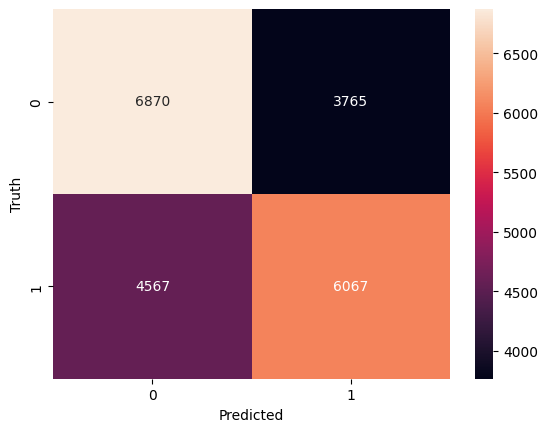

In [20]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap (cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [21]:
reviews=[
    "Samsung is better than Apple",
    "Apple and Samsung are good companies"
]

In [22]:
model.predict(reviews)

1/1 [==============================] - 1s 1s/step


array([[0.66285545],
       [0.6646902 ]], dtype=float32)